In [405]:
#Load the model and dependencies
import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import pickle
import cv2, numpy as np
from deconv_utils import *
import copy

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [441]:
#Load the VGG Model and ImageNet Class Mappings
from cs231n.classifiers.pretrained_vgg16 import PretrainedVGG
model = PretrainedVGG(h5_file = 'vgg/vgg16_weights.h5')
CLASSES = pickle.load(open('vgg/CLASSES.pkl'))

In [555]:
#Input Image File
filename = 'person.jpg'
#Layer from which the image will be segment
layer = 11
#No of neurons to evaluate from ranked list
kmax = 7

In [556]:
im = load_image_cv2(filename)
activs, caches = get_activs(model, im)
# class_no = np.argmax(activs[15][0])
# print class_no, CLASSES[class_no]
print [CLASSES[i] for i in np.argsort(-activs[15][0])[:5]]
print  np.argsort(-activs[15][0])[:5]

['swimming trunks, bathing trunks', 'jean, blue jean, denim', 'sunglasses, dark glasses, shades', 'fur coat', 'miniskirt, mini']
[842 608 837 568 655]


In [557]:
#Get Actives & Cache -Blob

#class_no=264
print CLASSES[class_no]
#Get Backgrad Up until the layer of choice
#This is used to rank the neurons to obtain best blobs
back_grad = get_backgrad(activs, model, class_no, layer, caches)

#Get the Filters of Interest in Sorted Order
amax = filter_of_intr(activs,back_grad,kmax,layer)
filter_scores = get_filter_scores(
    amax, model, im, activs,caches, layer, class_no,
    percentile_thresh=40,use_blob=True)

Cardigan, Cardigan Welsh corgi
410 (10, 7)
0 0 0 0
score = -0.106025
459 (11, 7)
0 0 0 0
score = -0.063225
331 (11, 8)
0 0 0 0
score = 0.694512
44 (12, 7)
0 0 0 0
score = 0.0965499
79 (10, 7)
0 0 0 0
score = -0.405075
414 (6, 10)
0 0 0 0
score = -0.0552277
470 (11, 8)
0 0 0 0
score = 0.738021


0.0965499


(-0.5, 223.5, 223.5, -0.5)

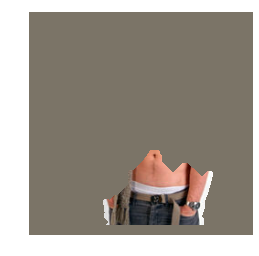

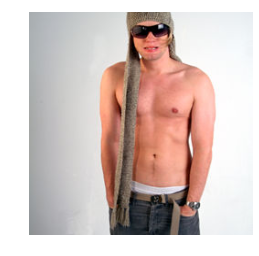

In [558]:
#Union Blobs
sorted_scores = sorted(filter_scores,key=lambda x:-x[1])
mask = np.zeros(im.shape)
for k in range(3):
    i,n_score,blob,xmin,xmax,ymin,ymax=sorted_scores[k]
    mask = (mask+blob)>0
newim = im.copy()*mask
#plt.imshow(newim[0].transpose(1,2,0))
plot_image_cv2(newim.copy())
plt.axis("off")
print n_score
plt.figure()
plot_image_cv2(im)
plt.axis("off")

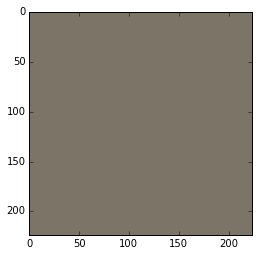

In [529]:


idxs = np.where(np.sum(mask,axis = 1)>0)[0]
xmin,xmax = min(idxs),max(idxs)
idxs = np.where(np.sum(mask,axis = 0)>0)[0]
ymin,ymax = min(idxs),max(idxs)

mask2 = np.zeros(im.shape)
mask2[0,:,xmin:(xmax+1),ymin:(ymax+1)] = 1
#mask[0,:,xmin:(xmax+1),:] = 1
newim = im.copy()*mask2
plot_image_cv2(newim)

341 hog, pig, grunter, squealer, Sus scrofa
92 (2, 7)
0 0 0 0
score = 5.36473
206 (2, 6)
0 0 0 0
score = 4.99263
45 (4, 6)
0 0 0 0
score = 2.78154
311 (2, 7)
0 0 0 0
score = 4.22629
75 (2, 6)
0 0 0 0
score = 4.19142
67 (3, 7)
0 0 0 0
score = 5.16978
226 (2, 7)
0 0 0 0
score = 5.36473
5.36473


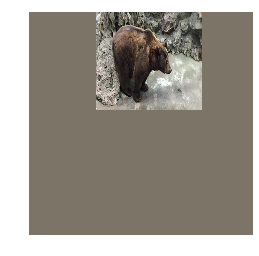

In [521]:
#Get Actives & Cache - no Blob
im = load_image_cv2(filename)
activs, caches = get_activs(model, im)
#class_no = np.argmax(activs[15][0])
print class_no, CLASSES[class_no]
#class_no=341
#Get Backgrad Up until the layer of choice
#This is used to rank the neurons to obtain best blobs
back_grad = get_backgrad(activs, model,class_no, layer, caches)

#Get the Filters of Interest in Sorted Order
amax = filter_of_intr(activs,back_grad,kmax,layer)
filter_scores = get_filter_scores(
    amax, model, im, activs,caches, layer, class_no,
    percentile_thresh=80,use_blob=False)


#Union Blobs
mask = np.zeros(im.shape)
for k in range(1):
    i,n_score,blob,xmin,xmax,ymin,ymax=sorted(filter_scores,key=lambda x:-x[1])[k]
    mask = (mask+blob)>0
newim = im.copy()*mask
#plt.imshow(newim[0].transpose(1,2,0))
plot_image_cv2(newim)
plt.axis("off")
print n_score

(-0.5, 223.5, 223.5, -0.5)

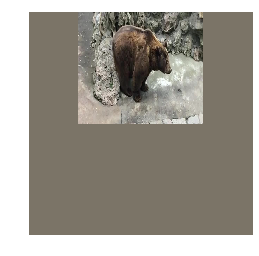

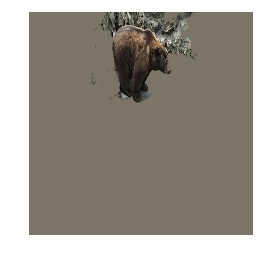

In [522]:
#GrabCut version of UnionBlob
im2 = im[0].transpose(1,2,0).astype('uint8')
im3 = load_image_cv2(filename)
ymin = xmin= 100000
ymax = xmax= -100000
for k in range(5):
    i,n_score,blob,xmin2,xmax2,ymin2,ymax2=sorted(filter_scores,key=lambda x:-x[1])[k]
    xmin = min(xmin,xmin2)
    ymin = min(ymin,ymin2)
    ymax = max(ymax,ymax2)
    xmax = max(xmax,xmax2)

bmask = np.zeros(im.shape)
bmask[0,:,xmin:xmax,ymin:ymax]=1
plot_image_cv2(im*bmask)
plt.axis("off")
mask = grabCut(im2,xmin,xmax,ymin,ymax)>0
mask2 = np.zeros(im3.shape)
mask2[:,0,:,:]= mask2[:,1,:,:]= mask2[:,2,:,:]= mask
newim = im3.copy()*mask2

#plt.imshow(newim[0].transpose(1,2,0))
# im3 = cv2.cvtColor(newim, cv2.cv.CV_BGR2RGB)
# plt.imshow(im3)
plt.figure()
plot_image_cv2(newim)
#plt.imshow(mask)
plt.axis("off")

In [523]:
newim[0,:,112,112]

array([ 103.939,  116.779,  123.68 ])

In [524]:
mask2[0,:,112,112]

array([ 0.,  0.,  0.])

In [565]:
filter(lambda x:"dog" in x.lower(), CLASSES)

['Maltese dog, Maltese terrier, Maltese',
 'Tibetan terrier, chrysanthemum dog',
 'Old English sheepdog, bobtail',
 'Shetland sheepdog, Shetland sheep dog, Shetland',
 'German shepherd, German shepherd dog, German police dog, alsatian',
 'Greater Swiss Mountain dog',
 'Bernese mountain dog',
 'French bulldog',
 'Eskimo dog, husky',
 'dalmatian, coach dog, carriage dog',
 'affenpinscher, monkey pinscher, monkey dog',
 'pug, pug-dog',
 'Newfoundland, Newfoundland dog',
 'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
 'dogsled, dog sled, dog sleigh',
 'hotdog, hot dog, red hot']

In [573]:
print(CLASSES[:5])

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark']


In [560]:
a.lower?

In [572]:
[x.split() for x in (open("words.txt")).readlines()]

[['n00001740', 'entity'],
 ['n00001930', 'physical', 'entity'],
 ['n00002137', 'abstraction,', 'abstract', 'entity'],
 ['n00002452', 'thing'],
 ['n00002684', 'object,', 'physical', 'object'],
 ['n00003553', 'whole,', 'unit'],
 ['n00003993', 'congener'],
 ['n00004258', 'living', 'thing,', 'animate', 'thing'],
 ['n00004475', 'organism,', 'being'],
 ['n00005787', 'benthos'],
 ['n00005930', 'dwarf'],
 ['n00006024', 'heterotroph'],
 ['n00006150', 'parent'],
 ['n00006269', 'life'],
 ['n00006400', 'biont'],
 ['n00006484', 'cell'],
 ['n00007347', 'causal', 'agent,', 'cause,', 'causal', 'agency'],
 ['n00007846',
  'person,',
  'individual,',
  'someone,',
  'somebody,',
  'mortal,',
  'soul'],
 ['n00015388',
  'animal,',
  'animate',
  'being,',
  'beast,',
  'brute,',
  'creature,',
  'fauna'],
 ['n00017222', 'plant,', 'flora,', 'plant', 'life'],
 ['n00019046', 'native'],
 ['n00019128', 'natural', 'object'],
 ['n00019613', 'substance'],
 ['n00020090', 'substance'],
 ['n00020827', 'matter'],
 [